# Train a Small LLM

# Install Libraries

In [1]:
%%bash
pip -q install trl
pip -q install peft
pip -q install torch
pip install tiktoken
pip -q install datasets
pip -q install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import Libraries

In [4]:
import torch
from trl import SFTTrainer
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_int8_training
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments

# Dataset Exploration

In [5]:
train_dataset = load_dataset("tatsu-lab/alpaca", split="train")

print(train_dataset)

Dataset({
    features: ['instruction', 'input', 'output', 'text'],
    num_rows: 52002
})


In [6]:
# We can get the first five rows as follows
pandas_format = train_dataset.to_pandas()
display(pandas_format.head())

,instruction,input,output,text
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,Below is an instruction that describes a task....
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",Below is an instruction that describes a task....
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",Below is an instruction that describes a task....
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...,Below is an instruction that describes a task....
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...,Below is an instruction that describes a task....


In [12]:
!pip -q install textwrap3

In [13]:
import textwrap

In [16]:
for index in range(3):
  print("---"*15)
  print("Instruction: {}".format(textwrap.fill(pandas_format.iloc[index]["instruction"], width=50)))
  print("Output: {}".format(textwrap.fill(pandas_format.iloc[index]["output"], width=50)))
  print("Text: {}".format(textwrap.fill(pandas_format.iloc[index]["text"], width=50)))

---------------------------------------------
Instruction: Give three tips for staying healthy.
Output: 1.Eat a balanced diet and make sure to include
plenty of fruits and vegetables.  2. Exercise
regularly to keep your body active and strong.  3.
Get enough sleep and maintain a consistent sleep
schedule.
Text: Below is an instruction that describes a task.
Write a response that appropriately completes the
request.  ### Instruction: Give three tips for
staying healthy.  ### Response: 1.Eat a balanced
diet and make sure to include plenty of fruits and
vegetables.  2. Exercise regularly to keep your
body active and strong.  3. Get enough sleep and
maintain a consistent sleep schedule.
---------------------------------------------
Instruction: What are the three primary colors?
Output: The three primary colors are red, blue, and
yellow.
Text: Below is an instruction that describes a task.
Write a response that appropriately completes the
request.  ### Instruction: What are the three
prima

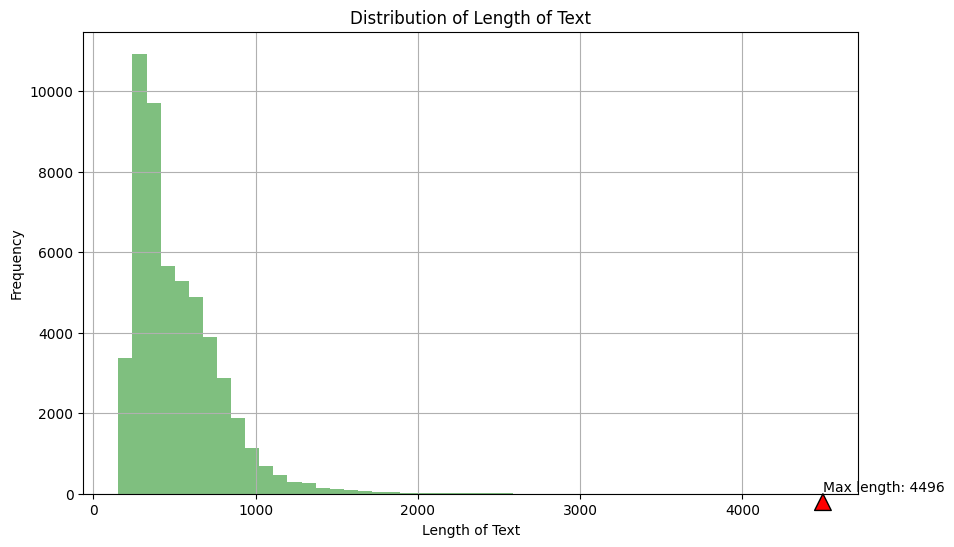

In [19]:
import matplotlib.pyplot as plt

pandas_format['text_length'] = pandas_format['text'].apply(len)

max_length = pandas_format['text_length'].max()

plt.figure(figsize=(10,6))
plt.hist(pandas_format['text_length'], bins=50, alpha=0.5, color='g')

plt.annotate('Max length: {}'.format(max_length), xy=(max_length, 0), xytext=(max_length, 50),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.title('Distribution of Length of Text')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [20]:
mask = pandas_format['text_length'] > 1024
percentage = (mask.sum() / pandas_format['text_length'].count()) * 100

print(f"The percentage of text documents with a length greater than 1024 is: {percentage}%")

The percentage of text documents with a length greater than 1024 is: 4.499826929733472%


# Model Training Prerequisites

The following prerequisites are required for successfully training the model:
- the pretrained model: *Salesforce/xgen-7b-8k-base* which is made freely available on Hugging Face by Salesforce. They trained a series of 7B LLMs named XGen-7B with standard dense attention on up to 8K sequence for up to 1.5T tokens. More information is available [here](https://blog.salesforceairesearch.com/xgen/)  
- Tokenizer: required for performing the tokenization tasks on the training data.

In [5]:
pretrained_model_name = "Salesforce/xgen-7b-8k-base"

In [6]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name, trust_remote_code=True)

Using unk_token, but it is not set yet.
Using unk_token, but it is not set yet.


In [7]:
model = AutoModelForCausalLM.from_pretrained(pretrained_model_name, torch_dtype=torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
model_training_args = TrainingArguments(
        output_dir="xgen-7b-8k-base-fine-tuned",
        per_device_train_batch_size=4,
        optim="adamw_torch",
        logging_steps=80,
        learning_rate=2e-4,
        warmup_ratio=0.1,
        lr_scheduler_type="linear",
        num_train_epochs=1,
        save_strategy="epoch"
    )

lora_peft_config = LoraConfig(r=16, lora_alpha=32, lora_dropout=0.05, task_type="CAUSAL_LM")

SFT_trainer = SFTTrainer(
        model=model,
        train_dataset=train_dataset,
        dataset_text_field="text",
        max_seq_length=1024,
        tokenizer=tokenizer,
        args=model_training_args,
        packing=True,
        peft_config=lora_peft_config,
    )

In [20]:
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))
model = prepare_model_for_int8_training(model)
model = get_peft_model(model, lora_peft_config)

In [20]:
training_args = model_training_args
trainer = SFT_trainer
trainer.train()